
## 딥 뉴럴 네트워크 기반 Resting-state fMRI 분석





<img src="https://drive.google.com/uc?id=1DgoQBoJX48EZpfgeP1TGPXeEgScQFPNI" width="750" height="350">


## **Dataset**

### **Resting-state fMRI** 
ADNI (Alzheimer's Disease Neuroimaging Initiative) \\
ADNI2 dataset  -  eMCI (Mild Cognitive Impairment) & CN (Cognitive Normal) \\
http://adni.loni.usc.edu/ \\
31 early MCI (14F/ 17M) and 30 CN (17F/ 14M) \\
Repetition time = 3,000ms \\
Echo time = 30ms \\
Flip angle = 80 \\degree
qcquisition matrix size = 64 x 64, 48 slices \\
140 volumes \\
voxel thickness = 3.3mm \\

##** Preprocessing**
Magnetization equilibrium 을 위해 각 피험자의 데이터를 앞에서부터 10 volume 제거 \\
AAL template 이용하여 116 Regions Of Interest (ROIs)으로 parcellation \\
ROI intensity는 각 ROI에 포함되는 voxel들의 mean time-series \\
0.01~0.08 Hz 의 band-pass filter 적용 \\
각 피험자마다 ROI-wise Gaussian Normalization 적용 \\

**Subjects: 61, fMRI time scans: 130, ROIs: 116**

1.   모델 구성
> * Auto-encoder
> * Stacked-auto-encoder
> * Sparse auto-encoder
> * L1/ L2 regularization  적용
> * 분류 - Support vector machine, Logistic Regression 

2.  시각화
> * Auto-encoder의 input/ output  비교
> * ICA 와의 비교
 

In [0]:
# Dataset download
!wget -nc -q https://github.com/ku-milab/Neuroimage-Analysis-Tutorial/raw/master/data/KHBM_ADNI_eMCINC_ERES.mat

## **Library Download**

In [0]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import sklearn
import sys
from IPython.display import Image, display

tf.set_random_seed(20180818)
np.random.seed(20180818)

In [2]:
# nilearn(Machine learning for Neuro-Imaging in Python) 라이브러리 다운로드 
# 시각화 함수 제공
# https://nilearn.github.io/index.html#

!pip install nilearn

In [3]:
# Tensorboard 설정
!rm -rf colab_utils
!git clone https://github.com/mixuala/colab_utils.git
import colab_utils.tboard as tboard
summ_path = "./log/"
ROOT=%pwd
tboard.launch_tensorboard(bin_dir=ROOT, log_dir=summ_path)

Cloning into 'colab_utils'...
remote: Counting objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 65.93 KiB | 5.49 MiB/s, done.
Resolving deltas: 100% (97/97), done.
ngrok installed
status: tensorboard=True, ngrok=True
tensorboard url= http://6df90927.ngrok.io


'http://6df90927.ngrok.io'

In [4]:

fMRI_data = scipy.io.loadmat("./KHBM_ADNI_eMCINC_ERES.mat")['Data']

print(fMRI_data.shape)
print('Subjects: %d, fMRI time scans: %d, ROIs: %d' % (fMRI_data.shape[0], fMRI_data.shape[1], fMRI_data.shape[2]))

# 학습을 위해 데이터 배열 변경 3D >> 2D 
# 하나의 fMRI scan이 하나의 샘플 데이터
ROISignals = fMRI_data.reshape(-1, fMRI_data.shape[-1]).copy()
print(ROISignals.shape)
print('Subjects*fMRI time scans: %d, ROIs: %d '% (ROISignals.shape[0], ROISignals.shape[1]))

(61, 130, 116)
Subjects: 61, fMRI time scans: 130, ROIs: 116
(7930, 116)
Subjects*fMRI time scans: 7930, ROIs: 116 


## **Auto-encoder** /  Stacked Auto-encoder

<img src="https://drive.google.com/uc?id=1R1k3SHuCfc6gTijifGJ9SEJVPhPtDpZH" width="1000" height="500">








In [0]:
## 학습 파라미터 설정
learning_rate = 0.001 
num_steps = 10
batch_size = 10
activation_function = 'sigmoid' # Other option: 'relu' 'tanh' 'softplus'
display_step = 100

# 가중치 L1 regularization
l1_reg = False 
lamda_l1 = tf.constant(0.1)

# 가중치 L2 regularization
l2_reg = True
lamda_l2 = tf.constant(0.001)

# Sparse autoencoder: Hidden unit activation sparsity
sparsity = False
rho = tf.constant(0.05)
beta = tf.constant(0.2)

# Sparse autoencoder: Hidden unit activation sparsity  - L1 regularization
sparsity2 = False
lamda_l1_sparsity =  tf.constant(0.01)


## 데이터 입력
num_input = ROISignals.shape[1] # 입력값의 크기 =  ROI의 수 = 116
# shape = [batch (batch_size = 10), 입력값의 크기 (ROI의 수 = 116)]
# dtype = 데이터의 실수 표현(32 bit) 
X = tf.placeholder(shape=[None, num_input], dtype=tf.float32)

## 신경망 모델 구성
# Encoder 구성
encoder_arch = [num_input, 40] 
# Decoder 구성        
decoder_arch = [encoder_arch[-1], num_input]     


weights_en = {}
biases_en = {}
weights_de = {}
biases_de = {}

# Encoder layer 와 Decoder layer 가중치 및 바이어스 초기화
for e in range(len(encoder_arch)-1):
  weights_en.update({'encoder_h%d'% (e+1) : tf.Variable(tf.random_normal([encoder_arch[e], encoder_arch[e+1]]))}) 
  biases_en.update({'encoder_b%d'% (e+1) : tf.Variable(tf.random_normal([encoder_arch[e+1]]))}) 
    
for d in range(len(decoder_arch)-1):
  weights_de.update({'decoder_h%d'% (d+1) : tf.Variable(tf.random_normal([decoder_arch[d], decoder_arch[d+1]]))}) 
  biases_de.update({'decoder_b%d'% (d+1) : tf.Variable(tf.random_normal([decoder_arch[d+1]]))}) 



In [0]:
def linear( input_val, weights, biases ):
  output = tf.matmul( input_val, weights )
  output = tf.add( output, biases )
  return output

In [0]:

# 인코더 레이어 구성
layer_en = {}
def encoder(x, encoder_arch=encoder_arch, activeF=activation_function):   
      
    for e in range(len(encoder_arch)-1):
        layer = linear(layer_en['layer_en_%d'% (e)] if e != 0 else x, weights_en['encoder_h%d'% (e+1)], biases_en['encoder_b%d' % (e+1)])

        if activeF == 'sigmoid':
          layer = tf.nn.sigmoid(layer)
        
        elif activeF == 'relu':
          layer = tf.nn.relu(layer)

        elif activeF == 'tanh':
          layer = tf.nn.tanh(layer)

        elif activeF == 'softplus':
          layer = tf.nn.softplus(layer)

        layer_en.update({'layer_en_%d'%(e+1): layer})
    
    return layer_en['layer_en_%d' % (len(encoder_arch)-1)]


In [0]:

# 디코더 레이어 구성
layer_de = {}
def decoder(x, decoder_arch=decoder_arch, activeF=activation_function):

    for d in range(len(decoder_arch)-1):
        layer = linear(layer_de['layer_de_%d'% (d)] if d != 0 else x, weights_de['decoder_h%d'% (d+1)], biases_de['decoder_b%d' % (d+1)])

      # 마지막 레이어의 경우 activation fucntion = identity
        if d == (len(decoder_arch)-2):
            layer = tf.identity(layer)
            layer_de.update({'layer_de_%d'%(d+1): layer})
        
        else:

            if activeF == 'sigmoid':
                layer = tf.nn.sigmoid(layer)

            elif activeF == 'relu':
                layer = tf.nn.relu(layer)

            elif activeF == 'tanh':
                layer = tf.nn.tanh(layer)

            elif activeF == 'softplus':
                layer = tf.nn.softplus(layer)

            layer_de.update({'layer_de_%d'%(d+1): layer})

    return layer_de['layer_de_%d' % (len(decoder_arch)-1)]

In [0]:
## 신경망 모델

# 인코더
encoder_op = encoder(X, encoder_arch = encoder_arch, activeF = activation_function)
# 디코더
decoder_op = decoder(encoder_op, decoder_arch = decoder_arch, activeF = activation_function)



In [0]:
# 예측값: 디코더의 출력값
y_pred = decoder_op

# 실제값: 인코더의 입력값
y_true = X


## **Sparse Auto-encoder** 
<img src="https://drive.google.com/uc?id=1B6PaxdB70088BWLz9W15XT7ptFjM8twG"  width="1000" height="500">


## ** L1 Regularization **

<img src= "https://drive.google.com/uc?id=1cGoIL7Csw54Shk5vwxIb5stqeQuAuik1" width="1000" height="500">

## ** L2 Regularization **
<img src="https://drive.google.com/uc?id=1hFKEaTACxy8XS4mgUMh1IOwk3q1Lf-DE" width="1000" height="500">





In [0]:
# 손실값 설정
total_loss = tf.reduce_mean( tf.square(y_true-y_pred))

# Encoder/ Decoder의 가중치에 l1-regularization 적용
if l1_reg == True:
  
  print('L1 regularization on weights')
  encoder_l1_reg = []
  for e in range(len(encoder_arch)-1):
    encoder_l1_reg.append(tf.reduce_sum(tf.abs(weights_en['encoder_h%d' % (e+1)])))                          
  print(encoder_l1_reg)
  decoder_l1_reg = []
  for d in range(len(decoder_arch)-1):
    decoder_l1_reg.append(tf.reduce_sum(tf.abs(weights_de['decoder_h%d' % (d+1)])))
  print(decoder_l1_reg)

  total_l1loss_en = tf.reduce_sum(encoder_l1_reg)
  total_l1loss_de = tf.reduce_sum(decoder_l1_reg)
                                             
  total_l1_loss = lamda_l1*(total_l1loss_en + total_l1loss_de)
  total_loss  = total_loss + total_l1_loss 

# Encoder/ Decoder의 가중치에 l2-regularization 적용
if l2_reg == True:
  
  encoder_l2_reg = []
  for e in range(len(encoder_arch)-1):
    encoder_l2_reg.append(tf.nn.l2_loss(weights_en['encoder_h%d' % (e+1)]))                          
  
  decoder_l2_reg = []
  for d in range(len(decoder_arch)-1):
    decoder_l2_reg.append(tf.nn.l2_loss(weights_de['decoder_h%d' % (d+1)]))
  
  total_l2loss_en = tf.reduce_sum(encoder_l2_reg)
  total_l2loss_de = tf.reduce_sum(decoder_l2_reg)
                          
                          
  total_l2_loss = lamda_l2*(total_l2loss_en + total_l2loss_de)
  total_loss  = total_loss + total_l2_loss 


# hidden layer unit activation에 대한 sparsity 적용
if sparsity == True:
  
  print('KL divergence sparsity')
  def kl_divergence(rho, rho_hat):
      return rho * tf.log(rho) - rho * tf.log(rho_hat + tf.constant(1e-6)) + (1 - rho) * tf.log(1 - rho) - (1 - rho) * tf.log(1 - rho_hat+ tf.constant(1e-6))
  
  # 각 Hidden layer에서의 sparsity 적용
  # stability를 위해 episilon 
  kl_en = []
  for e in range(1, len(encoder_arch)):
    rho_hat_en = tf.reduce_mean(layer_en['layer_en_%d'% (e)], axis=0)
    kl_en.append(beta*(tf.reduce_sum(kl_divergence(rho, rho_hat_en))))
  
  kl_de = []
  for d in range(len(decoder_arch)-2):
    rho_hat_de = tf.reduce_mean(layer_de['layer_de_%d'% (d+1)], axis=0)
    kl_de.append(beta*(tf.reduce_sum(kl_divergence(rho, rho_hat_de))))

    
  total_sparse_en = tf.reduce_sum(kl_en)
  total_sparse_de = tf.reduce_sum(kl_de)
  sparsity_loss = total_sparse_en + total_sparse_de
  
  total_loss = total_loss + sparsity_loss

if sparsity2 == True:
  print('L1 regularization sparsity')
  l1_hidden_en = []
  for e in range(1, len(encoder_arch)):
    l1_hidden_loss_en = tf.reduce_mean(tf.abs(layer_en['layer_en_%d' % e]), axis=0)  
    l1_hidden_en.append(lamda_l1_sparsity*(tf.reduce_sum(l1_hidden_loss_en)))

  l1_hidden_de = []
  for d in range(len(decoder_arch)-2):
    l1_hidden_loss_de = tf.reduce_mean(tf.abs(layer_de['layer_de_%d'% (d+1)]), axis=0)
    l1_hidden_de.append(lamda_l1_sparsity*(tf.reduce_sum(l1_hidden_loss_de)))

  total_sparse2_en = tf.reduce_sum(l1_hidden_en)
  total_sparse2_de = tf.reduce_sum(l1_hidden_de)
  sparsity2_loss = total_sparse2_en + total_sparse2_de

  total_loss = total_loss + sparsity2_loss

  
  
# loss 값의 변화를 tensorboard 에 기록
tf.summary.scalar( 'Loss', total_loss ) 

# 최적화 함수 - 손실값 최소화
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(total_loss)

In [0]:
# 텐서보드 변수 요약 함수
summary_op =  tf.summary.merge_all()

# 모든 변수 초기화 함수
init = tf.global_variables_initializer()

In [13]:
## 신경망 모델 학습

# tensorflow session 선언
sess = tf.Session()

# 모든 변수 초기화
sess.run( init )

# 텐서보드 
train_writer = tf.summary.FileWriter( summ_path, sess.graph )
# 모델 저장 함수
saver = tf.train.Saver()


# 신경망 모델 배치 단위 학습 
for epoch in range(num_steps):
  randidx = np.random.permutation( np.arange(ROISignals.shape[0], dtype=np.uint32) ) # ROISignals.shape[0] = 데이터 샘플 수 

  for i in range(ROISignals.shape[0]//batch_size): 
    offset = i%(ROISignals.shape[0]//batch_size)
    # 배치 설정 
    batch_x = ROISignals[randidx[offset*batch_size:(offset+1)*batch_size]].copy()

    # Run optimization op (backprop) and cost op (to get loss value)
    _, l, l_tsb = sess.run( [optimizer, total_loss, summary_op], feed_dict={X: batch_x} )
    
    # 표기
    if i%display_step == 0:
      train_writer.add_summary(l_tsb, i)
      print('Epoch %i, Step %i: Minibatch Loss: %f' % (epoch+1, i, l))

# 모델 저장
saver.save( sess, summ_path+'saved_model.ckpt' )


Epoch 1, Step 0: Minibatch Loss: 22.818779
Epoch 1, Step 100: Minibatch Loss: 17.287342
Epoch 1, Step 200: Minibatch Loss: 13.315304
Epoch 1, Step 300: Minibatch Loss: 11.211246
Epoch 1, Step 400: Minibatch Loss: 10.771423
Epoch 1, Step 500: Minibatch Loss: 9.256357
Epoch 1, Step 600: Minibatch Loss: 7.944324
Epoch 1, Step 700: Minibatch Loss: 8.077626
Epoch 2, Step 0: Minibatch Loss: 6.345959
Epoch 2, Step 100: Minibatch Loss: 6.906613
Epoch 2, Step 200: Minibatch Loss: 5.356789
Epoch 2, Step 300: Minibatch Loss: 5.015252
Epoch 2, Step 400: Minibatch Loss: 5.513278
Epoch 2, Step 500: Minibatch Loss: 4.679025
Epoch 2, Step 600: Minibatch Loss: 4.749650
Epoch 2, Step 700: Minibatch Loss: 3.958403
Epoch 3, Step 0: Minibatch Loss: 3.630366
Epoch 3, Step 100: Minibatch Loss: 3.553087
Epoch 3, Step 200: Minibatch Loss: 3.269704
Epoch 3, Step 300: Minibatch Loss: 2.983671
Epoch 3, Step 400: Minibatch Loss: 2.815095
Epoch 3, Step 500: Minibatch Loss: 2.832799
Epoch 3, Step 600: Minibatch Loss

'./log/saved_model.ckpt'

## Classification


In [0]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.model_selection import train_test_split

fMRI_data_labels = scipy.io.loadmat("./KHBM_ADNI_eMCINC_ERES.mat")['Labels']
fMRI_data_labels = np.squeeze(fMRI_data_labels)

In [17]:
# 모든 변수 초기화
sess.run( init )

# 모델 저장 함수 & 불러오기
saver.restore(sess, summ_path + 'saved_model.ckpt')

# Encoder 의 마지막 레이어
# e = len(encoder_arch)-1
allsubs_encoder_output = []
for i in range(fMRI_data.shape[0]): # subject 수
  e = len(encoder_arch)-1
  sub_encoder_output = sess.run(layer_en['layer_en_%d'% (e)], {X: fMRI_data[i,:, :]})
  allsubs_encoder_output.append(sub_encoder_output)
allsubs_encoder_output = np.asarray(allsubs_encoder_output)


# Feature: Correlation map
def upper_tri_indexing(A):
    m = A.shape[0]
    r,c = np.triu_indices(m,1)
    return A[r,c]

Feature = []
for i in range(allsubs_encoder_output.shape[0]):
  subSignals = allsubs_encoder_output[i, :, :]
  corrMap = np.corrcoef(np.transpose(subSignals))
  Feature.append(upper_tri_indexing(corrMap))
Feature = np.asarray(Feature)
print(Feature.shape)


# PCA를 이용한 차원축소
ncs = 10
pca = PCA(n_components=ncs)
Feature_pca = pca.fit(Feature).transform(Feature)
print(Feature_pca.shape)

# Train/ Test 데이터
trainFeature, testFeature, train_label, test_label = train_test_split(Feature_pca, fMRI_data_labels, test_size=0.1, random_state=42)
 

INFO:tensorflow:Restoring parameters from ./log/saved_model.ckpt
(61, 780)
(61, 10)


In [18]:
# SVM classifier
clf = SVC(C = 0.01)
clf.fit(trainFeature, train_label)
acc = clf.score(testFeature, test_label)
print("Accuracy: %.2f" % acc)


Accuracy: 0.71


In [19]:
# Logistic regression
logreg = linear_model.LogisticRegression(C=0.1)
logreg.fit(trainFeature, train_label)
acc = logreg.score(testFeature, test_label)

print("Accuracy: %.2f" % acc)

Accuracy: 0.43


In [20]:
# 모든 변수 초기화
sess.run( init )

# 모델 저장 함수 & 불러오기
saver.restore(sess, summ_path + 'saved_model.ckpt')

subject_num = 2
output = sess.run(decoder_op, {X: fMRI_data[subject_num-1,:, :]})


INFO:tensorflow:Restoring parameters from ./log/saved_model.ckpt


## **Visualization**

## ICA vs. DNN

<img src="https://drive.google.com/uc?id=1P6XSiXIzdnBXi7qYs0PgJCb0Qzc3pf2w"  width="1000" height="500">


In [21]:
# 시각화: 입력값과 출력값 fMRI 비교
from nilearn import datasets
from nilearn import plotting
from nilearn import regions

# AAL 116 Atlas 다운로드 
atlas_data = datasets.fetch_atlas_aal(version='SPM12', verbose=1)
atlas_filename= atlas_data.maps


/usr/local/lib/python3.6/dist-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in catch_config_e

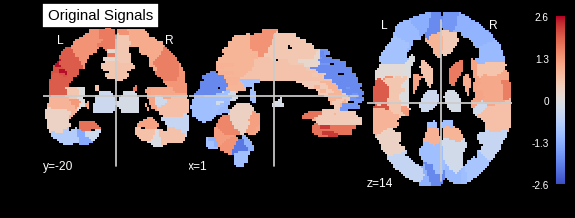

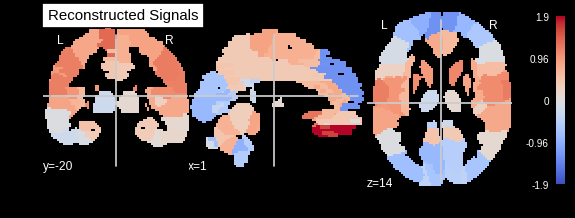

In [22]:
timescan = 10
# 입력값
# regions.signals_to_img_labels: 116 ROI 신호를 기존의 voxel 단위의 신호로 재구성
# signals = [fMRI time scan 수, ROI의 수]
# labels_img = AAL atlas, AAL atlas 의 116개의 라벨을 이용하여 signal 재구성
# mask_img = None, mask 에 해당하는 ROI만 함수를 실행하는 함수, 여기서는 116 ROI 전체에 적용할 것이기 때문에 None 으로 설정
# background_label = 0, 신호가 없는 부분은 intensity 0으로 처리
mkmaps_origin = regions.signals_to_img_labels(signals=fMRI_data[subject_num-1,:, :], labels_img = atlas_filename, mask_img=None, background_label=0, order='F' )
# 130개의 time scan 중 slice 선택
mkmaps_origin = mkmaps_origin.slicer[:, :, :, timescan]

# 시각화 함수
# stat_map_img: 시각화 하고자 하는 fMRI 신호 입력
# bg_img  = AAL atals, AAL atlas에 stat_map_img를 시각화
# cut_coords = x y z coordinates
plotBrain_origin = plotting.plot_stat_map(stat_map_img=mkmaps_origin, bg_img=atlas_filename, colorbar=True, cut_coords = [1, -20, 14], cmap= 'coolwarm', title='Original Signals' )
plotting.show()

# 출력값
mkmaps_recon = regions.signals_to_img_labels(output, atlas_filename, mask_img = None, background_label=0, order='F')
mkmaps_recon = mkmaps_recon.slicer[:, :, :, timescan]
plotBrain_recon = plotting.plot_stat_map(mkmaps_recon, atlas_filename, colorbar=True, cut_coords = [1, -20, 14], cmap= 'coolwarm', title='Reconstructed Signals' )
plotting.show()


## **ICA**

**ICA 와 Auto-encoder 의 비교**



In [23]:
## ICA

from sklearn.decomposition import FastICA

# ICA component 수 설정
n_components = 20

# ICA 함수 실행 
# 입력값 ( 7920 samples, 116 features)

ica = FastICA( n_components=n_components, random_state=42 )
components_masked = ica.fit_transform(ROISignals).T 
# (sample 수, ICA component 수)
print( components_masked.shape )

mixing_matrix = ica.mixing_
print( mixing_matrix.shape)


(20, 7930)
(116, 20)


ICA component 15


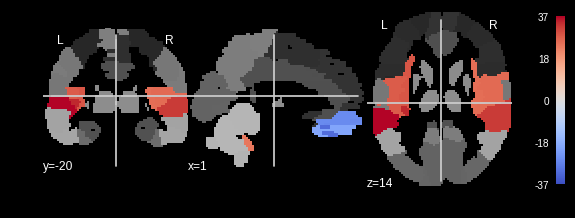

In [46]:
component = 15
print('ICA component %d' % component)

mixing_matrix = mixing_matrix.T

# Thresholding
mixing_matrix[np.abs(mixing_matrix) < (mixing_matrix.mean(axis=0)+1.5*(mixing_matrix.std(axis=0)))] = 0

mkmaps_ica = regions.signals_to_img_labels(mixing_matrix, atlas_filename, mask_img = None, background_label=0, order='F')
mkmaps_ica = mkmaps_ica.slicer[:,:,:, component-1]

plotBrain_ica = plotting.plot_stat_map(mkmaps_ica, atlas_filename, colorbar=True, cmap = 'coolwarm', cut_coords = [1, -20, 14])
plotting.show()


In [25]:
## Auto-encoder 

# 모든 변수 초기화
sess.run(init)

# 모델 저장 함수 & 불러오기
saver.restore(sess, summ_path + 'saved_model.ckpt')

weights_dict = sess.run(weights_de)
AE_mixing_matrix = weights_dict['decoder_h%d' % (len(decoder_arch)-1)]

INFO:tensorflow:Restoring parameters from ./log/saved_model.ckpt


Autoencoder weights component 39


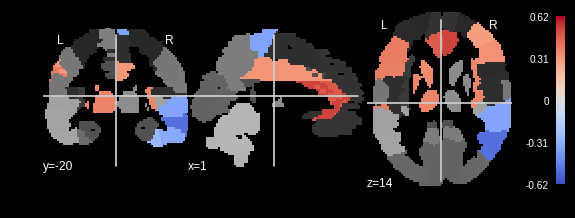

In [71]:
AE_component = 39 #Please choose the component
print('Autoencoder weights component %d' % AE_component)

AE_mixing_matrix[np.abs(AE_mixing_matrix) < (AE_mixing_matrix.mean(axis=0)+1.5*(AE_mixing_matrix.std(axis=0)))] = 0

mkmaps_AE = regions.signals_to_img_labels(AE_mixing_matrix, atlas_filename, mask_img = None, background_label=0, order='F')
mkmaps_AE = mkmaps_AE.slicer[:,:,:, AE_component-1]

plotBrain_ae = plotting.plot_stat_map(mkmaps_AE, atlas_filename, colorbar=True, cmap = 'coolwarm', cut_coords=[1, -20, 14])
plotting.show()
